#1번

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            if img.dtype == torch.uint8:
                print('flow')
                img = F.to_pil_image((img).to("cpu"))
            else: #torch.float32
                print('RGB')
                img = F.to_pil_image(unorm(img).to("cpu"))

            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

In [2]:
from PIL import Image
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torchvision

image_folder = r'/content/drive/MyDrive/주용햄딥러닝/dataset'

class DepthDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        #self.depth_files = [f for f in os.listdir(root_dir) if f.endswith('.depth.exr.tiff')]
        self.rgb_files = [f for f in os.listdir(root_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.rgb_files)

    def __getitem__(self, idx):
        #depth_path = os.path.join(self.root_dir, self.depth_files[idx])
        rgb_path = os.path.join(self.root_dir, self.rgb_files[idx])

        #depth_image = T.ToTensor()(np.array(Image.open(depth_path)))
        rgb_image = torchvision.io.read_image(rgb_path)

        if self.transform:
            #depth_image = self.transform(depth_image)
            rgb_image = self.transform(rgb_image)

        return rgb_image#, depth_image

transform = T.Compose(
    [
        T.ConvertImageDtype(torch.float32),
        T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
    ]
)


dataset = DepthDataset(image_folder, transform)
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        if tensor.dim == 4:
            for t, m, s in zip(tensor, self.mean, self.std):
                t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        else:
            tensor.mul_(self.std).add_(self.mean)
        return tensor
unorm = UnNormalize(mean=(0.5), std=(0.5))

rgb1 = dataset[52]
rgb_un1 = unorm(rgb1).permute((1,2,0))

rgb2= dataset[54]
rgb_un2 = unorm(rgb2).permute((1,2,0))

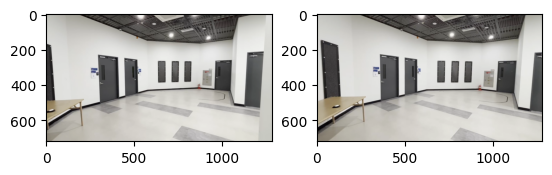

In [3]:
plt.subplot(1,2,1); plt.imshow(rgb_un1)
plt.subplot(1,2,2); plt.imshow(rgb_un2)

0 torch.Size([32, 3, 720, 1280])
1 torch.Size([32, 3, 720, 1280])
2 torch.Size([32, 3, 720, 1280])
RGB
RGB
RGB
RGB


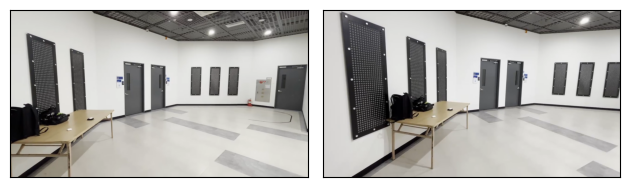

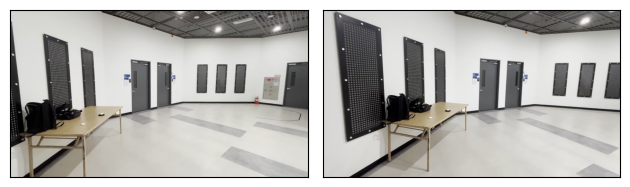

In [4]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

for cnt, (imgs) in enumerate(dataloader):
    print(cnt, imgs.shape)
    if cnt >= 2:
        break

img1_batch = imgs[[0,-2]]
img2_batch = imgs[[2,-1]]

plot(img1_batch)
plot(img2_batch)

In [5]:
# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = img1_batch.to(device)
img2_batch = img2_batch.to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([2, 3, 720, 1280]), dtype = torch.float32


In [6]:
from torchvision.models.optical_flow import raft_large

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/raft_large_C_T_SKHT_V2-ff5fadd5.pth" to /root/.cache/torch/hub/checkpoints/raft_large_C_T_SKHT_V2-ff5fadd5.pth
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STA

type = <class 'list'>
length = 12 = number of iterations of the model


In [7]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([2, 2, 720, 1280]) = (N, 2, H, W)
min = -46.28664016723633, max = 93.22636413574219


In [8]:
predicted_flows.dtype, img1_batch[0].dtype, predicted_flows.shape, img1_batch[0].shape

(torch.float32,
 torch.float32,
 torch.Size([2, 2, 720, 1280]),
 torch.Size([3, 720, 1280]))

RGB
flow
RGB
flow


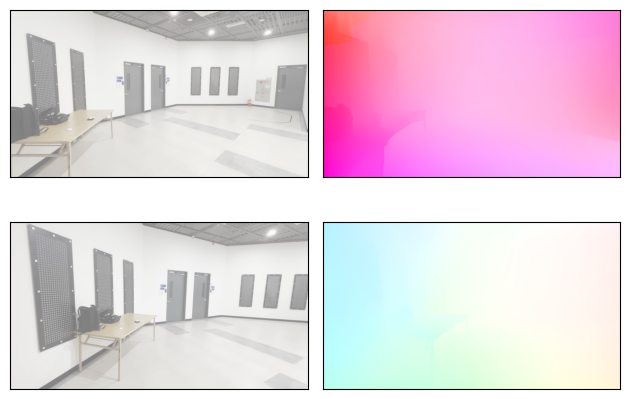

In [9]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)

(720, 1280, 3) (2, 720, 1280)
(3600,) (3600,)
(720, 1280, 3) (2, 720, 1280)
(3600,) (3600,)


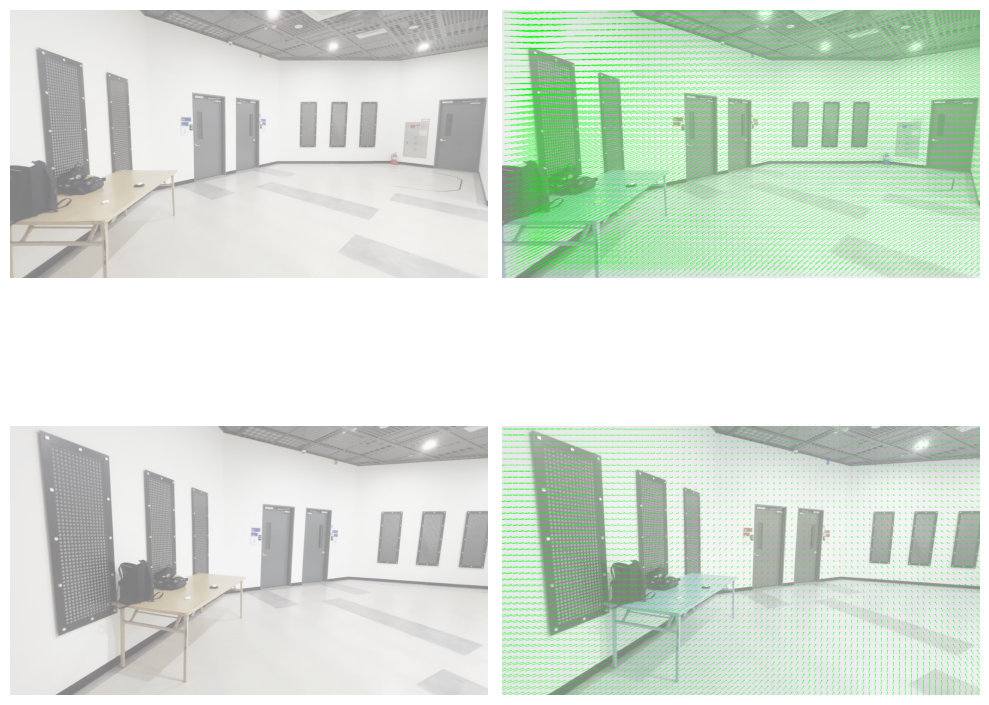

In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torchvision.utils import flow_to_image

def draw_flow(img, flow, step=16):
    """Draws optical flow arrows on the image."""
    print(img.shape, flow.shape)
    # flow = flow.permute((1,2,0))
    flow = flow.transpose((1,2,0))
    h, w = img.shape[:2]
    y, x = np.mgrid[step//2:h:step, step//2:w:step].reshape(2, -1).astype(int)
    # print(x, y)
    fx, fy = flow[y, x].T

    # Create a mask that will be used for drawing
    print(x.shape, fx.shape)
    lines = np.vstack([x, y, x + fx, y + fy]).T.reshape(-1, 2, 2)
    lines = np.int32(lines + 0.5)

    # print(img.shape)
    vis = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    # vis = np.array(img)

    # Draw the lines on the image
    cv2.polylines(vis, lines, isClosed=False, color=(0, 255, 0))

    # Draw the endpoints of the flow vectors
    for (x1, y1), (_x2, _y2) in lines:
        cv2.circle(vis, (x1, y1), 1, (0, 255, 0), -1)
    return vis

# Assuming predicted_flows is a batch of flow vectors and img1_batch is a batch of images
flow_imgs = flow_to_image(predicted_flows)  # Convert flow vectors to images

predicted_flows_np = predicted_flows.cpu().detach().numpy()
# Draw optical flow on images
flow_visualizations = [draw_flow(img1.cpu().numpy().transpose(1, 2, 0), flow_img) for img1, flow_img in zip(img1_batch, predicted_flows_np)]

# Setup for plotting
fig, axs = plt.subplots(len(flow_visualizations), 2, figsize=(10, len(flow_visualizations) * 5))

for i, (img, flow_viz) in enumerate(zip(img1_batch, flow_visualizations)):
    img_cpu = img.cpu().numpy()  # GPU에서 CPU로 img 텐서 이동
    axs[i, 0].imshow(img_cpu.transpose(1, 2, 0), cmap='gray')  # Numpy 배열 변환 후 축 전환
    axs[i, 0].axis('off')
    axs[i, 1].imshow(flow_viz)
    axs[i, 1].axis('off')

plt.tight_layout()
plt.show()

# 2번

Epoch [10/300], Loss: 0.0868, Val Loss: 0.0736
Epoch [20/300], Loss: 0.0341, Val Loss: 0.0579
Epoch [30/300], Loss: 0.0256, Val Loss: 0.0553
Epoch [40/300], Loss: 0.0481, Val Loss: 0.0387
Epoch [50/300], Loss: 0.0488, Val Loss: 0.0300
Epoch [60/300], Loss: 0.0211, Val Loss: 0.0261
Epoch [70/300], Loss: 0.0099, Val Loss: 0.0282
Epoch [80/300], Loss: 0.0226, Val Loss: 0.0208
Epoch [90/300], Loss: 0.0093, Val Loss: 0.0169
Epoch [100/300], Loss: 0.0079, Val Loss: 0.0142
Epoch [110/300], Loss: 0.0235, Val Loss: 0.0152
Epoch [120/300], Loss: 0.0063, Val Loss: 0.0146
Epoch [130/300], Loss: 0.0062, Val Loss: 0.0116
Epoch [140/300], Loss: 0.0082, Val Loss: 0.0126
Epoch [150/300], Loss: 0.0065, Val Loss: 0.0090
Epoch [160/300], Loss: 0.0146, Val Loss: 0.0071
Epoch [170/300], Loss: 0.0382, Val Loss: 0.0129
Epoch [180/300], Loss: 0.0141, Val Loss: 0.0073
Epoch [190/300], Loss: 0.0049, Val Loss: 0.0094
Epoch [200/300], Loss: 0.0095, Val Loss: 0.0061
Epoch [210/300], Loss: 0.0060, Val Loss: 0.0048
E

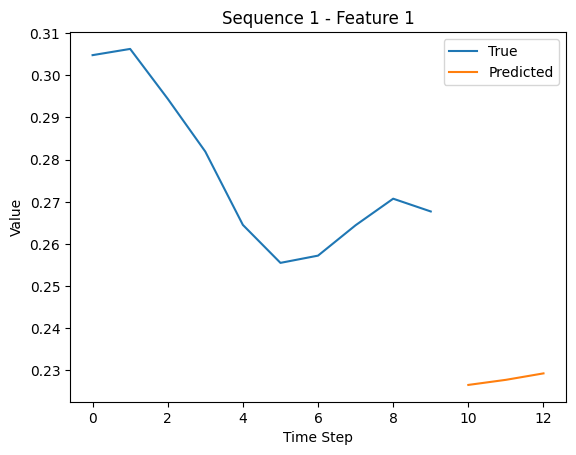

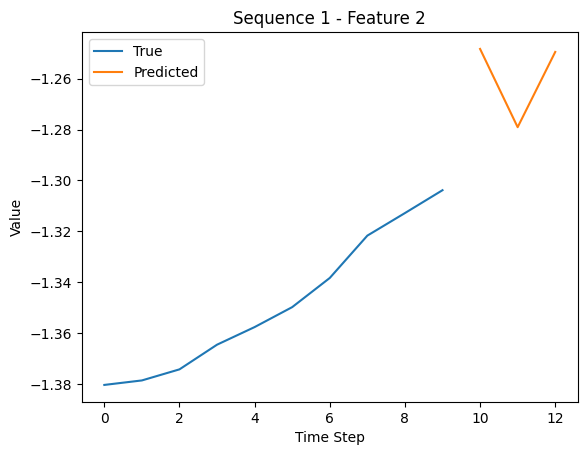

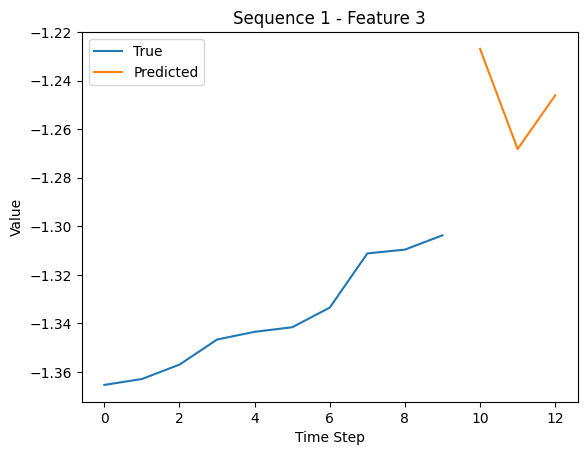

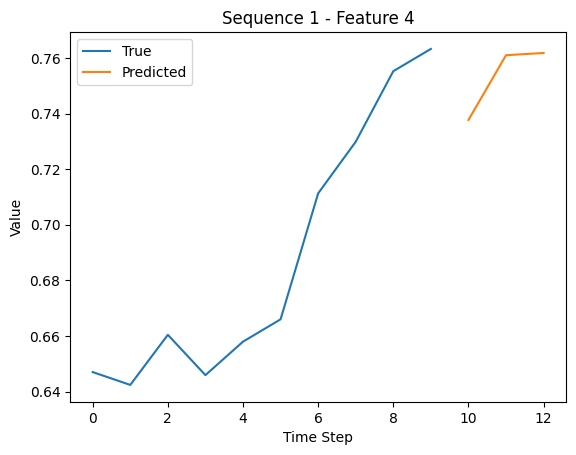

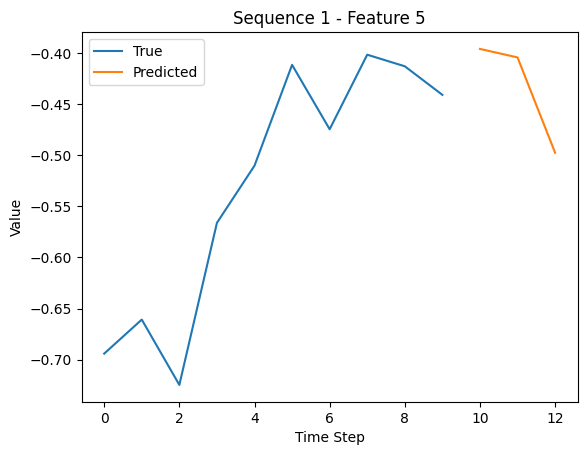

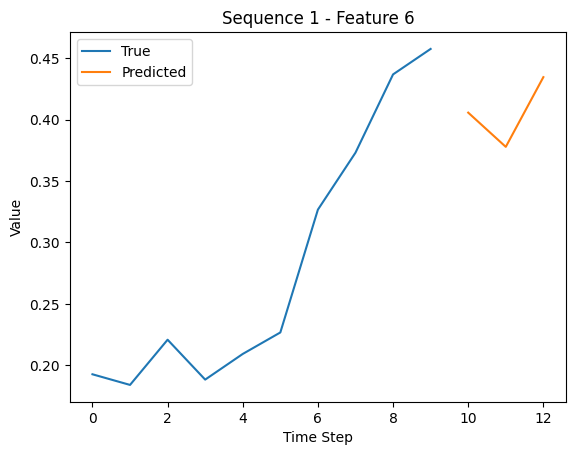

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Load the data
data = pd.read_csv('/content/drive/MyDrive/주용햄딥러닝/team1_transformed_data.csv')  # CSV 파일 경로를 정확히 입력하세요.

# Standardize the data
scaler = StandardScaler()
data.iloc[:, 1:] = scaler.fit_transform(data.iloc[:, 1:])

# Prepare the data
sequence_length = 10
predict_length = 3

X = []
y = []

for i in range(len(data) - sequence_length - predict_length):
    X.append(data.iloc[i:i+sequence_length, 1:].values)  # 첫 번째 열(#name)을 제외하고 나머지 열들을 사용
    y.append(data.iloc[i+sequence_length:i+sequence_length+predict_length, 1:].values)

X = np.array(X)
y = np.array(y)

X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define the LSTM model
class ImprovedLSTMPosePredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, predict_length):
        super(ImprovedLSTMPosePredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, output_dim * predict_length)
        self.predict_length = predict_length
        self.output_dim = output_dim

    def forward(self, x):
        h_0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(x.device)
        c_0 = torch.zeros(num_layers, x.size(0), hidden_dim).to(x.device)
        out, _ = self.lstm(x, (h_0, c_0))
        out = self.fc(out[:, -1, :])
        return out.view(-1, self.predict_length, self.output_dim)

input_dim = X.shape[2]
hidden_dim = 100  # Increase the number of hidden units
output_dim = y.shape[2]
num_layers = 3  # Add more layers
num_epochs = 300  # Increase the number of epochs
learning_rate = 0.001

model = ImprovedLSTMPosePredictor(input_dim, hidden_dim, output_dim, num_layers, predict_length)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model with early stopping
best_loss = float('inf')
patience = 10
trigger_times = 0

for epoch in range(num_epochs):
    for sequences, targets in dataloader:
        model.train()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Early stopping
    if (epoch+1) % 10 == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for sequences, targets in dataloader:
                outputs = model(sequences)
                val_loss += criterion(outputs, targets).item()
        val_loss /= len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), 'best_pose_prediction_model.pth')
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print('Early stopping!')
                break

# Load the best model
model.load_state_dict(torch.load('best_pose_prediction_model.pth'))

# Function to predict the next 3 poses for a given sequence
def predict_next_poses(sequence, model, predict_length=3):
    model.eval()
    current_sequence = torch.tensor(sequence, dtype=torch.float32).unsqueeze(0)

    with torch.no_grad():
        prediction = model(current_sequence)

    return prediction.squeeze().numpy()

# Example usage
example_sequence = data.iloc[:sequence_length, 1:].values
next_poses = predict_next_poses(example_sequence, model)
print(next_poses)

# Visualization of the results
def visualize_predictions(true_sequences, predicted_sequences, start_idx=0, num_sequences=1):
    for i in range(num_sequences):
        true_sequence = true_sequences[start_idx + i]
        predicted_sequence = predicted_sequences[start_idx + i]

        for j in range(true_sequence.shape[1]):
            plt.figure()
            plt.plot(range(sequence_length), true_sequence[:, j], label='True')
            plt.plot(range(sequence_length, sequence_length + predict_length), predicted_sequence[:, j], label='Predicted')
            plt.title(f'Sequence {start_idx + i + 1} - Feature {j + 1}')
            plt.xlabel('Time Step')
            plt.ylabel('Value')
            plt.legend()
            plt.show()

# Visualize predictions for the first sequence
X_vis = X[:1]  # Visualize the first sequence
y_vis = y[:1]  # Corresponding true values

# Predict next poses for the visualization
predictions_vis = np.array([predict_next_poses(seq, model) for seq in X_vis])

visualize_predictions(X_vis, predictions_vis, start_idx=0, num_sequences=1)


#3번

In [2]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 12.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


/usr/local/lib/python3.10/dist-packages/torch/hub.py:293: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/rwightman/gen-efficientnet-pytorch/zipball/master" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_lite3-b733e338.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_lite3-b733e338.pth
Downloading: "https://github.

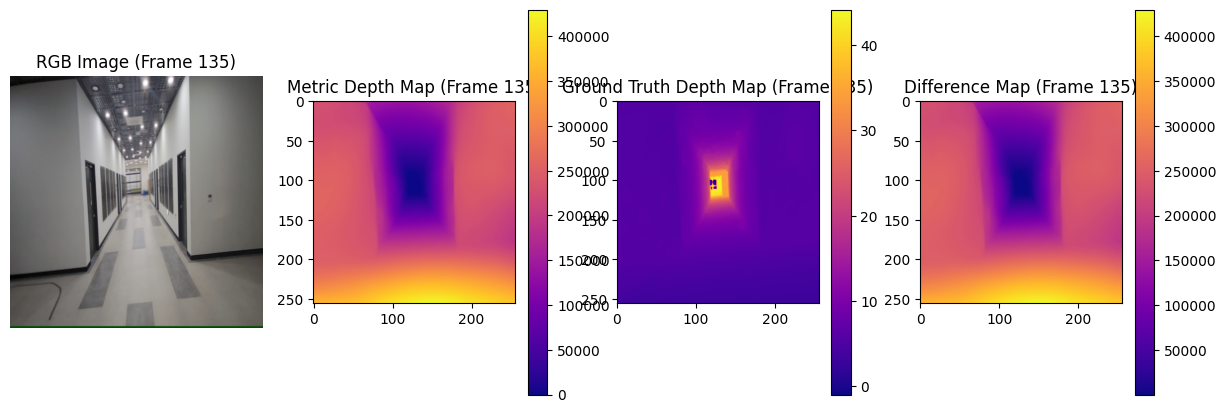

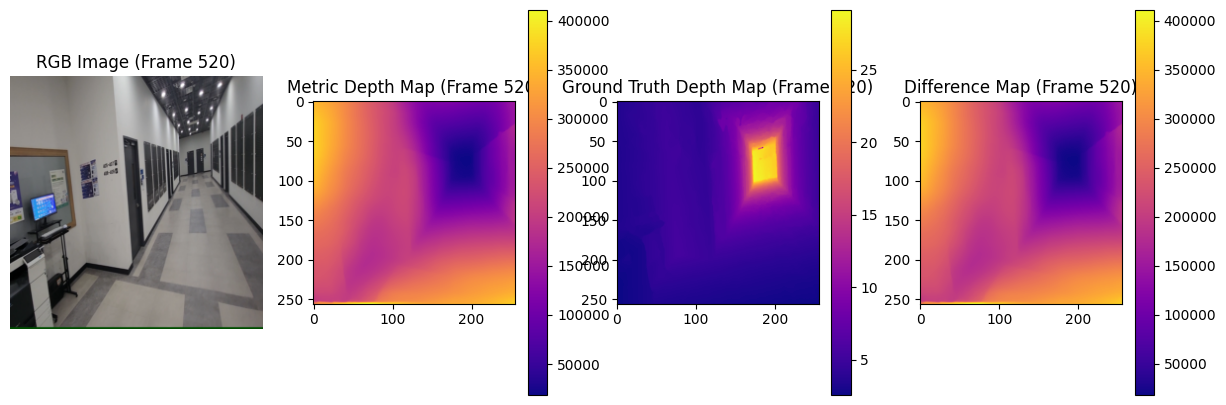

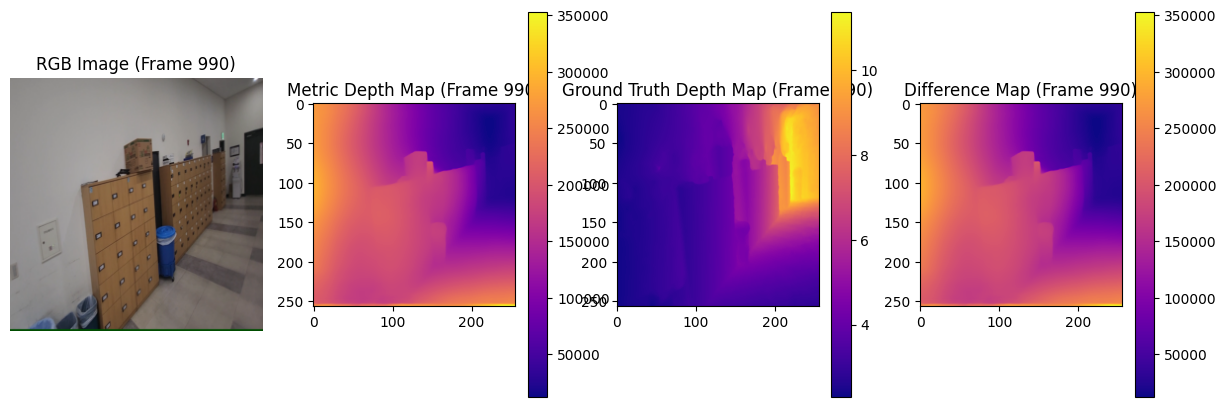

In [3]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor

# MiDAS model and transformation setup
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

# Utility function to convert disparity to depth
def convert_disparity_to_depth(disparity_map, baseline, focal_length):
    """Convert disparity map to depth map using baseline and focal length."""
    # Avoid division by zero by adding a small value to disparity_map
    depth_map = baseline * focal_length / (disparity_map + 1e-6)
    return depth_map

# Load image and ground truth maps
def load_image_and_gt(frame_number):
    """Load RGB image and ground truth depth map for a given frame number."""
    rgb_image = cv2.imread(f'/content/drive/MyDrive/주용햄딥러닝/resized_images/rgb_frame{frame_number:06d}.png')
    gt_depth_map = cv2.imread(f'/content/drive/MyDrive/주용햄딥러닝/resized_images/depth_20240501_184023.mp4_frame{frame_number:06d}.png.depth.exr.tiff', cv2.IMREAD_UNCHANGED)
    return rgb_image, gt_depth_map

# Predict depth map using MiDAS
def predict_disparity_map(image):
    """Predict depth map using MiDAS model."""
    input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_image = midas_transforms(input_image).to(device)

    with torch.no_grad():
        prediction = midas(input_image)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map

# Compare maps and display results
def compare_and_display_maps(frame_number, baseline, focal_length):
    """Compare MiDAS depth map with ground truth depth map and convert to metric depth map."""
    rgb_image, gt_depth_map = load_image_and_gt(frame_number)
    predicted_depth_map = predict_disparity_map(rgb_image)

    # Assume the MiDAS output is an inverse depth map (disparity-like)
    disparity_map = 1 / (predicted_depth_map + 1e-6)

    # Ensure the maps are float32 for accurate division
    disparity_map = disparity_map.astype(np.float32)
    gt_depth_map = gt_depth_map.astype(np.float32)

    # Convert MiDAS disparity map to metric depth map
    metric_depth_map = convert_disparity_to_depth(disparity_map, baseline, focal_length)

    # Calculate the absolute difference between the metric depth map and ground truth depth map
    diff_map = np.abs(metric_depth_map - gt_depth_map)

    # Display the results
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(rgb_image, cv2.COLOR_BGR2RGB))
    plt.title(f'RGB Image (Frame {frame_number})')
    plt.axis('off')

    plt.subplot(1, 4, 2)
    plt.imshow(metric_depth_map, cmap='plasma')
    plt.title(f'Metric Depth Map (Frame {frame_number})')
    plt.colorbar()

    plt.subplot(1, 4, 3)
    plt.imshow(gt_depth_map, cmap='plasma')
    plt.title(f'Ground Truth Depth Map (Frame {frame_number})')
    plt.colorbar()

    plt.subplot(1, 4, 4)
    plt.imshow(diff_map, cmap='plasma')
    plt.title(f'Difference Map (Frame {frame_number})')
    plt.colorbar()

    plt.show()

# Parameters (example values)
baseline = 0.54  # meters
focal_length = 721.0  # pixels

# Frames to process
frames = [135, 520, 990]

# Process each frame
for frame in frames:
    compare_and_display_maps(frame, baseline, focal_length)


Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /root/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /root/.cache/torch/hub/intel-isl_MiDaS_master


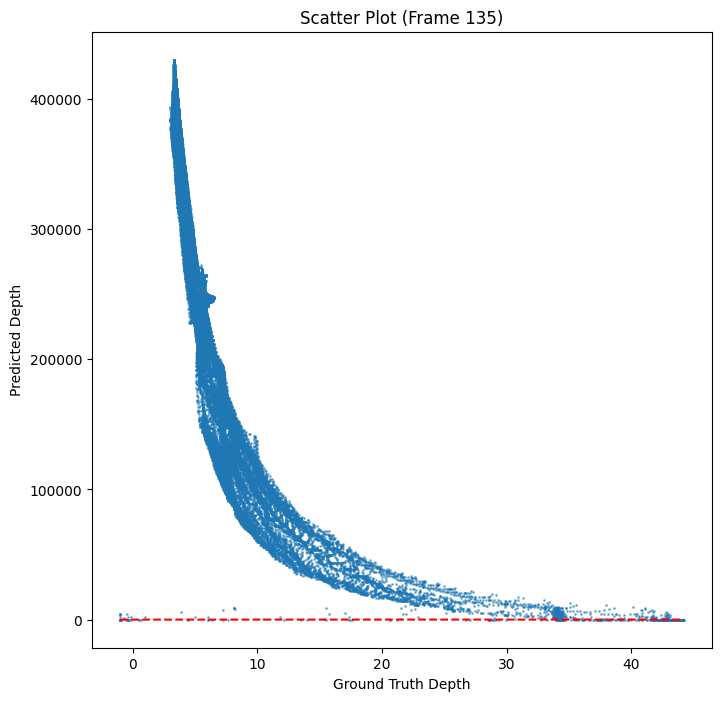

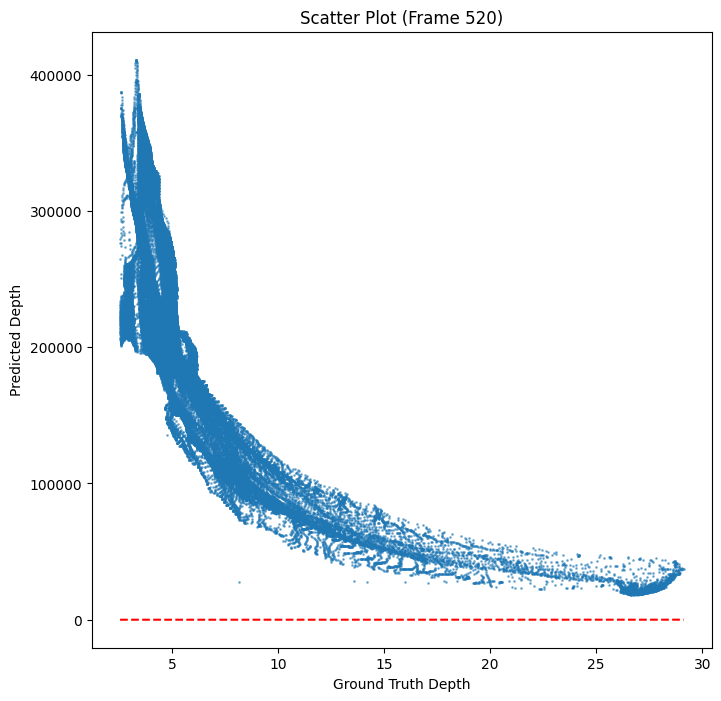

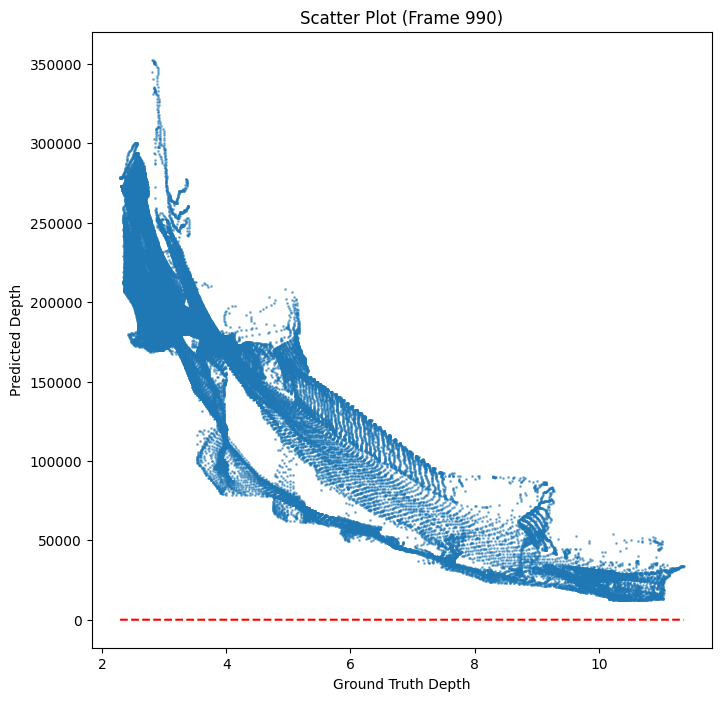

In [5]:
import torch
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import Compose, Resize, ToTensor

# MiDAS model and transformation setup
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
midas = torch.hub.load("intel-isl/MiDaS", model_type)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
midas.to(device)
midas.eval()

midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms").dpt_transform

# Utility function to convert disparity to depth
def convert_disparity_to_depth(disparity_map, baseline, focal_length):
    """Convert disparity map to depth map using baseline and focal length."""
    # Avoid division by zero by adding a small value to disparity_map
    depth_map = baseline * focal_length / (disparity_map + 1e-6)
    return depth_map

# Load image and ground truth maps
def load_image_and_gt(frame_number):
    """Load RGB image and ground truth depth map for a given frame number."""
    rgb_image = cv2.imread(f'/content/drive/MyDrive/주용햄딥러닝/resized_images/rgb_frame{frame_number:06d}.png')
    gt_depth_map = cv2.imread(f'/content/drive/MyDrive/주용햄딥러닝/resized_images/depth_20240501_184023.mp4_frame{frame_number:06d}.png.depth.exr.tiff', cv2.IMREAD_UNCHANGED)
    return rgb_image, gt_depth_map

# Predict depth map using MiDAS
def predict_disparity_map(image):
    """Predict depth map using MiDAS model."""
    input_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    input_image = midas_transforms(input_image).to(device)

    with torch.no_grad():
        prediction = midas(input_image)
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=image.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    depth_map = prediction.cpu().numpy()
    return depth_map

# Compare maps and display results
def compare_maps(frame_number, baseline, focal_length):
    """Compare MiDAS depth map with ground truth depth map and convert to metric depth map."""
    rgb_image, gt_depth_map = load_image_and_gt(frame_number)
    predicted_depth_map = predict_disparity_map(rgb_image)

    # Assume the MiDAS output is an inverse depth map (disparity-like)
    disparity_map = 1 / (predicted_depth_map + 1e-6)

    # Ensure the maps are float32 for accurate division
    disparity_map = disparity_map.astype(np.float32)
    gt_depth_map = gt_depth_map.astype(np.float32)

    # Convert MiDAS disparity map to metric depth map
    metric_depth_map = convert_disparity_to_depth(disparity_map, baseline, focal_length)

    return metric_depth_map, gt_depth_map

# Scatter plot for comparing GT depth and predicted depth
def plot_scatter(gt_depth, predicted_depth, frame_number):
    """Plot scatter plot comparing GT depth and predicted depth."""
    plt.figure(figsize=(8, 8))
    plt.scatter(gt_depth, predicted_depth, s=1, alpha=0.5)
    plt.title(f'Scatter Plot (Frame {frame_number})')
    plt.xlabel('Ground Truth Depth')
    plt.ylabel('Predicted Depth')
    plt.plot([gt_depth.min(), gt_depth.max()], [gt_depth.min(), gt_depth.max()], 'r--')  # y=x line for reference
    plt.show()

# Parameters (example values)
baseline = 0.54  # meters
focal_length = 721.0  # pixels

# Frames to process
frames = [135, 520, 990]

# Process each frame and plot scatter plots
for frame in frames:
    metric_depth_map, gt_depth_map = compare_maps(frame, baseline, focal_length)

    # Flatten the maps for scatter plot
    gt_depth_flat = gt_depth_map.flatten()
    predicted_depth_flat = metric_depth_map.flatten()

    # Plot scatter plot for each frame
    plot_scatter(gt_depth_flat, predicted_depth_flat, frame)
